# Expanding Horizons through Transfer Learning

Throughout the preceding notebooks, my focus was primarily on working with relatively small datasets, encompassing just 1% and 10% of the total data. However, in this particular notebook, my objective shifts towards harnessing the power of transfer learning as I endeavor to tackle the extensive and comprehensive Food101 Dataset in its entirety.

## What I am going to cover

1. Download and prepare 10% of all Food101 classes(7500+training images)
2. Training a transfer learning feature extraction model
3. Fine-tuning our feature extraction model(Food Vision mini) to beat the original Food101 paper with only 10% of the data
4. Evaluating Food vision  mini's prediction
5. Making predictions with Food vision mini in our own custom images

In [1]:
# Check to see the GPU
!nvidia-smi

Tue Oct 17 18:16:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Importing the helper funcions
!wget https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py

--2023-10-17 18:16:08--  https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10267 (10K) [text/plain]
Saving to: ‘script_functions.py’

script_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2023-10-17 18:16:08 (115 MB/s) - ‘script_functions.py’ saved [10267/10267]



In [3]:
# Import series of helper functions
from script_functions import create_tensorboard_callback, plot_loss_curve, unzip_data, compare_historys, walk_through_dir

## 101 Food clases : working with less data
The goal here is to beat tht original Food101 paper with 10% of the training data

The data comes from the original Food101 dataset but has already been preprocessed

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2023-10-17 18:16:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  72.2MB/s    in 24s     

2023-10-17 18:16:39 (63.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_per

In [6]:
# Setup the data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #  dont shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a bigger model with transfer learning on 10% of food 101 classes

The steps to follow:

1. Create a ModelCheckpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless(no top layers) Functional EfficienctNetB0 backboned model (create customized output layer)
4. Compile the mode
5. Perform feature extraction for 5 full passes(5 epochs on the train dataset on 15% of the data. to save epoch time)

In [7]:
# Ceate a checkpoint callback
checkpoint_path = '101_classes_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [8]:
# Create a data augmentation layer to incorporate right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup the data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaling(1/255.) # rescale input of images to between 0 an 1 requiered for models like ResNet50
], name='data_augmentation')

In [9]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup the model architecture with trainable
inputs = layers.Input(shape=(224, 224,3), name='input_layer')
x = data_augmentation(inputs) # augment images
x = base_model(x, training=False) # this will put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

# Creating the model
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of the model built
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15* len(test_data)), # validata only 15% of data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 131s 479ms/step - loss: 3.3572 - accuracy: 0.2719 - val_loss: 2.4849 - val_accuracy: 0.4642
Epoch 2/5
237/237 [==============================] - 80s 331ms/step - loss: 2.2001 - accuracy: 0.4974 - val_loss: 2.1082 - val_accuracy: 0.4952
Epoch 3/5
237/237 [==============================] - 71s 296ms/step - loss: 1.8085 - accuracy: 0.5666 - val_loss: 1.9469 - val_accuracy: 0.5082
Epoch 4/5
237/237 [==============================] - 64s 266ms/step - loss: 1.5982 - accuracy: 0.6081 - val_loss: 1.8650 - val_accuracy: 0.5167
Epoch 5/5
237/237 [==============================] - 60s 250ms/step - loss: 1.4557 - accuracy: 0.6338 - val_loss: 1.8265 - val_accuracy: 0.5244


The model achieves a  75% accuracy on the training set and a 55% on the validation set.

*Why the acccuracy metric in 100% correct?*

I set the validation steps to be on 15% of the data

In [12]:
# Evaluate on the whole test dataset
fine_extraction_results = model.evaluate(test_data)
fine_extraction_results

790/790 [==============================] - 62s 79ms/step - loss: 1.5903 - accuracy: 0.5817


[1.590252161026001, 0.5817425847053528]

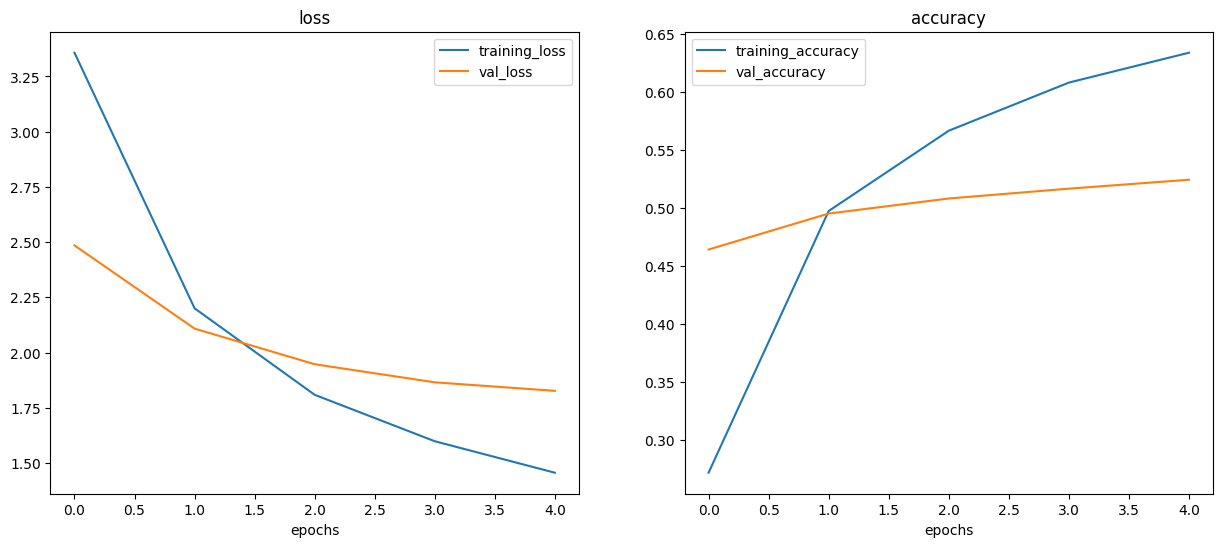

In [13]:
plot_loss_curve(history_all_classes_10_percent)

**Why are the curves so different?**

Ideally the 2 curves should be very similar to each other, if not, it may be that our model is overfitting and not generalizing to unseen datamm

## Fine Tuning

In [14]:
# Unfreeze all the layers in the base model
base_model.trainable =True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [16]:
# what layers are in the model
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

# Fine tuning the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.15* len(test_data)), # validata only 15% of data during training
                                           initial_epoch=history_all_classes_10_percent.epoch[-1],
                                           callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 74s 263ms/step - loss: 1.2020 - accuracy: 0.6857 - val_loss: 1.7794 - val_accuracy: 0.5336
Epoch 6/10
237/237 [==============================] - 53s 224ms/step - loss: 1.0892 - accuracy: 0.7105 - val_loss: 1.7848 - val_accuracy: 0.5334
Epoch 7/10
237/237 [==============================] - 54s 227ms/step - loss: 1.0153 - accuracy: 0.7314 - val_loss: 1.7394 - val_accuracy: 0.5503
Epoch 8/10
237/237 [==============================] - 54s 228ms/step - loss: 0.9405 - accuracy: 0.7473 - val_loss: 1.7759 - val_accuracy: 0.5389
Epoch 9/10
237/237 [==============================] - 49s 206ms/step - loss: 0.8743 - accuracy: 0.7645 - val_loss: 1.7700 - val_accuracy: 0.5392
Epoch 10/10
237/237 [==============================] - 48s 202ms/step - loss: 0.8381 - accuracy: 0.7757 - val_loss: 1.7756 - val_accuracy: 0.5400


In [19]:
# Evaluate
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 69s 88ms/step - loss: 1.4813 - accuracy: 0.6062


[1.4813460111618042, 0.6061782240867615]

In [20]:
import plotly.graph_objs as go
import plotly.subplots as sp

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compare the accuracy and loss using two separate subplots within the same figure.
    """
    # Get the original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine the original history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Create a figure with subplots
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
        subplot_titles=("Accuracy", "Loss"),
        row_heights=[0.5, 0.5]  # Equal height for both subplots
    )

    # Add training accuracy and validation accuracy to the first subplot
    fig.add_trace(go.Scatter(x=list(range(1, len(total_acc) + 1)), y=total_acc, mode='lines+markers',
                             name='Training Accuracy'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(1, len(total_val_acc) + 1)), y=total_val_acc, mode='lines+markers',
                             name='Validation Accuracy'), row=1, col=1)

    # Add training loss and validation loss to the second subplot
    fig.add_trace(go.Scatter(x=list(range(1, len(total_loss) + 1)), y=total_loss, mode='lines+markers',
                             name='Training Loss'), row=2, col=1)
    fig.add_trace(go.Scatter(x=list(range(1, len(total_val_loss) + 1)), y=total_val_loss, mode='lines+markers',
                             name='Validation Loss'), row=2, col=1)

    # Add a vertical line to indicate the start of fine-tuning
    fig.add_shape(type="line", x0=initial_epochs, x1=initial_epochs, y0=0, y1=1, line=dict(color="aqua", width=2),
                  xref="x", yref="paper", opacity=0.7)

    # Update layout
    fig.update_layout(
        title="Training and Validation Metrics",
        xaxis_title="Epoch",
        legend=dict(x=0.9, y=0.5),
        annotations=[dict(
            x=initial_epochs,
            y=1.05,
            xref="x",
            yref="paper",
            text="Start Fine Tuning",
            showarrow=True,
            arrowhead=2,
            arrowcolor="yellow",
            arrowsize=1,
        )]
    )

    # Display y-axis labels
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=2, col=1)

    # Increase the overall figure height
    fig.update_layout(height=800)  # Adjust the height as needed

    # Show the interactive plot
    fig.show()

# Example usage:
# compare_accuracy_and_loss(original_history, new_history)


In [21]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune, initial_epochs=5)

## Save and load the model

Save the model using joblib

In [22]:
# Save the fine tuned model
model.save('/content/drive/MyDrive/food-101/SavedModel/101_food_classes_10_percent')

In [23]:
# Load and evaluate the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/food-101/SavedModel/101_food_classes_10_percent')

In [24]:
# Evaluate loaded model and compare performance to presaved model
loaded_model_result = loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 68s 83ms/step - loss: 1.4813 - accuracy: 0.6062


[1.4813460111618042, 0.6061782240867615]

In [25]:
# Loaded model results should be very similar to the previous model
all_classes_10_percent_fine_tune_results

[1.4813460111618042, 0.6061782240867615]

## Evaluating the performance of the model across all different classes

Make some predictions, visualize them and the later find out which prediction were the 'most' wrong

In [26]:
# Make predictions with the loaded model
preds_probs = loaded_model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 72s 88ms/step


In [27]:
# how many predictions are there?
len(preds_probs)

25250

In [28]:
preds_probs.shape

(25250, 101)

In [29]:
# Explore what the first 10 predictions look like
preds_probs[:10]

array([[3.0094701e-01, 2.6198043e-04, 1.9564618e-01, ..., 2.2461776e-05,
        1.9147943e-03, 4.3628528e-03],
       [9.5848501e-01, 6.9572863e-08, 7.7358237e-04, ..., 6.2854029e-03,
        1.4923026e-07, 4.9802543e-06],
       [5.9448266e-01, 1.2684718e-02, 1.0895182e-02, ..., 4.3216650e-04,
        9.4156305e-04, 2.0887158e-03],
       ...,
       [2.2511038e-01, 9.0532230e-06, 1.4324470e-03, ..., 6.3122727e-02,
        1.0484726e-03, 1.0404382e-04],
       [2.2171833e-01, 4.0903932e-04, 2.5369751e-01, ..., 1.6108033e-04,
        2.4022745e-04, 1.7876040e-04],
       [5.5451804e-01, 1.2154910e-06, 1.0454658e-03, ..., 1.0439688e-02,
        1.1975394e-06, 6.4831018e-04]], dtype=float32)

In [30]:
# What does the first prediction look like
preds_probs[0], len(preds_probs[0])

(array([3.00947011e-01, 2.61980429e-04, 1.95646182e-01, 3.91222628e-08,
        1.54466250e-06, 5.57542535e-07, 8.89883013e-05, 6.85420582e-06,
        1.36224916e-02, 2.13898078e-04, 6.76425145e-07, 3.19964147e-06,
        4.76677757e-04, 1.87682858e-07, 4.79815900e-03, 6.32067793e-04,
        5.16246064e-06, 1.45878131e-03, 6.31929468e-03, 1.28309166e-05,
        3.60435108e-04, 1.19226261e-05, 1.50874039e-04, 8.29702767e-05,
        1.35857612e-03, 8.77658022e-04, 3.69574613e-04, 1.80015813e-05,
        2.13975415e-01, 1.11018564e-03, 1.05396930e-06, 8.71572469e-04,
        4.84152435e-04, 2.07338246e-07, 7.37108523e-03, 5.08483799e-06,
        4.39183423e-05, 1.22985523e-03, 7.11236075e-02, 5.40617111e-05,
        3.98252567e-04, 1.72262231e-03, 4.55587957e-04, 5.94689891e-06,
        7.68725149e-05, 5.70666543e-06, 2.03347486e-03, 3.81770806e-05,
        2.11426118e-06, 2.83344872e-02, 2.03567019e-04, 2.56491694e-05,
        2.80001592e-02, 1.11879418e-02, 1.99624938e-05, 2.734539

In [31]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 : {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
 [3.00947011e-01 2.61980429e-04 1.95646182e-01 3.91222628e-08
 1.54466250e-06 5.57542535e-07 8.89883013e-05 6.85420582e-06
 1.36224916e-02 2.13898078e-04 6.76425145e-07 3.19964147e-06
 4.76677757e-04 1.87682858e-07 4.79815900e-03 6.32067793e-04
 5.16246064e-06 1.45878131e-03 6.31929468e-03 1.28309166e-05
 3.60435108e-04 1.19226261e-05 1.50874039e-04 8.29702767e-05
 1.35857612e-03 8.77658022e-04 3.69574613e-04 1.80015813e-05
 2.13975415e-01 1.11018564e-03 1.05396930e-06 8.71572469e-04
 4.84152435e-04 2.07338246e-07 7.37108523e-03 5.08483799e-06
 4.39183423e-05 1.22985523e-03 7.11236075e-02 5.40617111e-05
 3.98252567e-04 1.72262231e-03 4.55587957e-04 5.94689891e-06
 7.68725149e-05 5.70666543e-06 2.03347486e-03 3.81770806e-05
 2.11426118e-06 2.83344872e-02 2.03567019e-04 2.56491694e-05
 2.80001592e-02 1.11879418e-02 1.99624938e-05 2.73453933e-03
 1.66292246e-02 2.02822429e-03 2.83511775e

In [32]:
test_data.class_names[28]

'croque_madame'

In [33]:
# Get the pred class of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  9,  0])

I've got the predictions array of the model's prediction. To evaluate them, I'll need to compare them to the original test dataset

In [34]:
# To get the test labels, unravel the test data batch dataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating the model's prediction
Use the accuracy score. Pretty convenient huh!

In [36]:
# Import accuracy score from scikit-learn
from sklearn.metrics import accuracy_score
sk_accuracy = accuracy_score(y_true=y_labels,
                             y_pred=pred_classes)
sk_accuracy

0.6061782178217822

In [37]:
# Does the metric come close to our model's evaluate results
import numpy as np
np.isclose(loaded_model_result[1], sk_accuracy)

True

In [38]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [39]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Chaged (plot x labels vertically ) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [40]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## Classification report

In [41]:
# Import from sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.23      0.26       250
           1       0.51      0.76      0.61       250
           2       0.72      0.56      0.63       250
           3       0.88      0.46      0.61       250
           4       0.59      0.31      0.41       250
           5       0.43      0.49      0.46       250
           6       0.72      0.81      0.76       250
           7       0.89      0.71      0.79       250
           8       0.30      0.52      0.38       250
           9       0.42      0.68      0.52       250
          10       0.56      0.39      0.46       250
          11       0.84      0.54      0.66       250
          12       0.70      0.63      0.66       250
          13       0.65      0.46      0.54       250
          14       0.52      0.56      0.54       250
          15       0.43      0.35      0.39       250
          16       0.61      0.61      0.61       250
          17       0.35    

With so many classes, the numbers are hard to understand

In [42]:
# Visualize the classification report in dictionary
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29292929292929293,
  'recall': 0.232,
  'f1-score': 0.2589285714285714,
  'support': 250},
 '1': {'precision': 0.5066666666666667,
  'recall': 0.76,
  'f1-score': 0.6080000000000001,
  'support': 250},
 '2': {'precision': 0.7157360406091371,
  'recall': 0.564,
  'f1-score': 0.6308724832214765,
  'support': 250},
 '3': {'precision': 0.8787878787878788,
  'recall': 0.464,
  'f1-score': 0.6073298429319371,
  'support': 250},
 '4': {'precision': 0.5864661654135338,
  'recall': 0.312,
  'f1-score': 0.40731070496083555,
  'support': 250},
 '5': {'precision': 0.43416370106761565,
  'recall': 0.488,
  'f1-score': 0.4595103578154426,
  'support': 250},
 '6': {'precision': 0.7188612099644128,
  'recall': 0.808,
  'f1-score': 0.760828625235405,
  'support': 250},
 '7': {'precision': 0.8944723618090452,
  'recall': 0.712,
  'f1-score': 0.7928730512249443,
  'support': 250},
 '8': {'precision': 0.2988505747126437,
  'recall': 0.52,
  'f1-score': 0.3795620437956205,
  'support'

In [43]:
class_names[70]

'pad_thai'

### Plot all the F1-Scores

In [44]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == 'accuracy': # stop once we get to accuracy key
     break
  else:
    # Add classnames and f1-score to new dictionay
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2589285714285714,
 'baby_back_ribs': 0.6080000000000001,
 'baklava': 0.6308724832214765,
 'beef_carpaccio': 0.6073298429319371,
 'beef_tartare': 0.40731070496083555,
 'beet_salad': 0.4595103578154426,
 'beignets': 0.760828625235405,
 'bibimbap': 0.7928730512249443,
 'bread_pudding': 0.3795620437956205,
 'breakfast_burrito': 0.5176110260336907,
 'bruschetta': 0.46226415094339623,
 'caesar_salad': 0.6585365853658537,
 'cannoli': 0.6624737945492662,
 'caprese_salad': 0.5420560747663552,
 'carrot_cake': 0.5377176015473888,
 'ceviche': 0.38666666666666666,
 'cheese_plate': 0.6092184368737474,
 'cheesecake': 0.391681109185442,
 'chicken_curry': 0.48659003831417624,
 'chicken_quesadilla': 0.6563106796116505,
 'chicken_wings': 0.727634194831014,
 'chocolate_cake': 0.570230607966457,
 'chocolate_mousse': 0.34751773049645385,
 'churros': 0.7221095334685598,
 'clam_chowder': 0.7116564417177914,
 'club_sandwich': 0.6971677559912853,
 'crab_cakes': 0.39495798319327735,
 'creme_brule

In [45]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33              edamame  0.964567
63             macarons  0.913934
69              oysters  0.850895
86              sashimi  0.841897
91  spaghetti_carbonara  0.837989

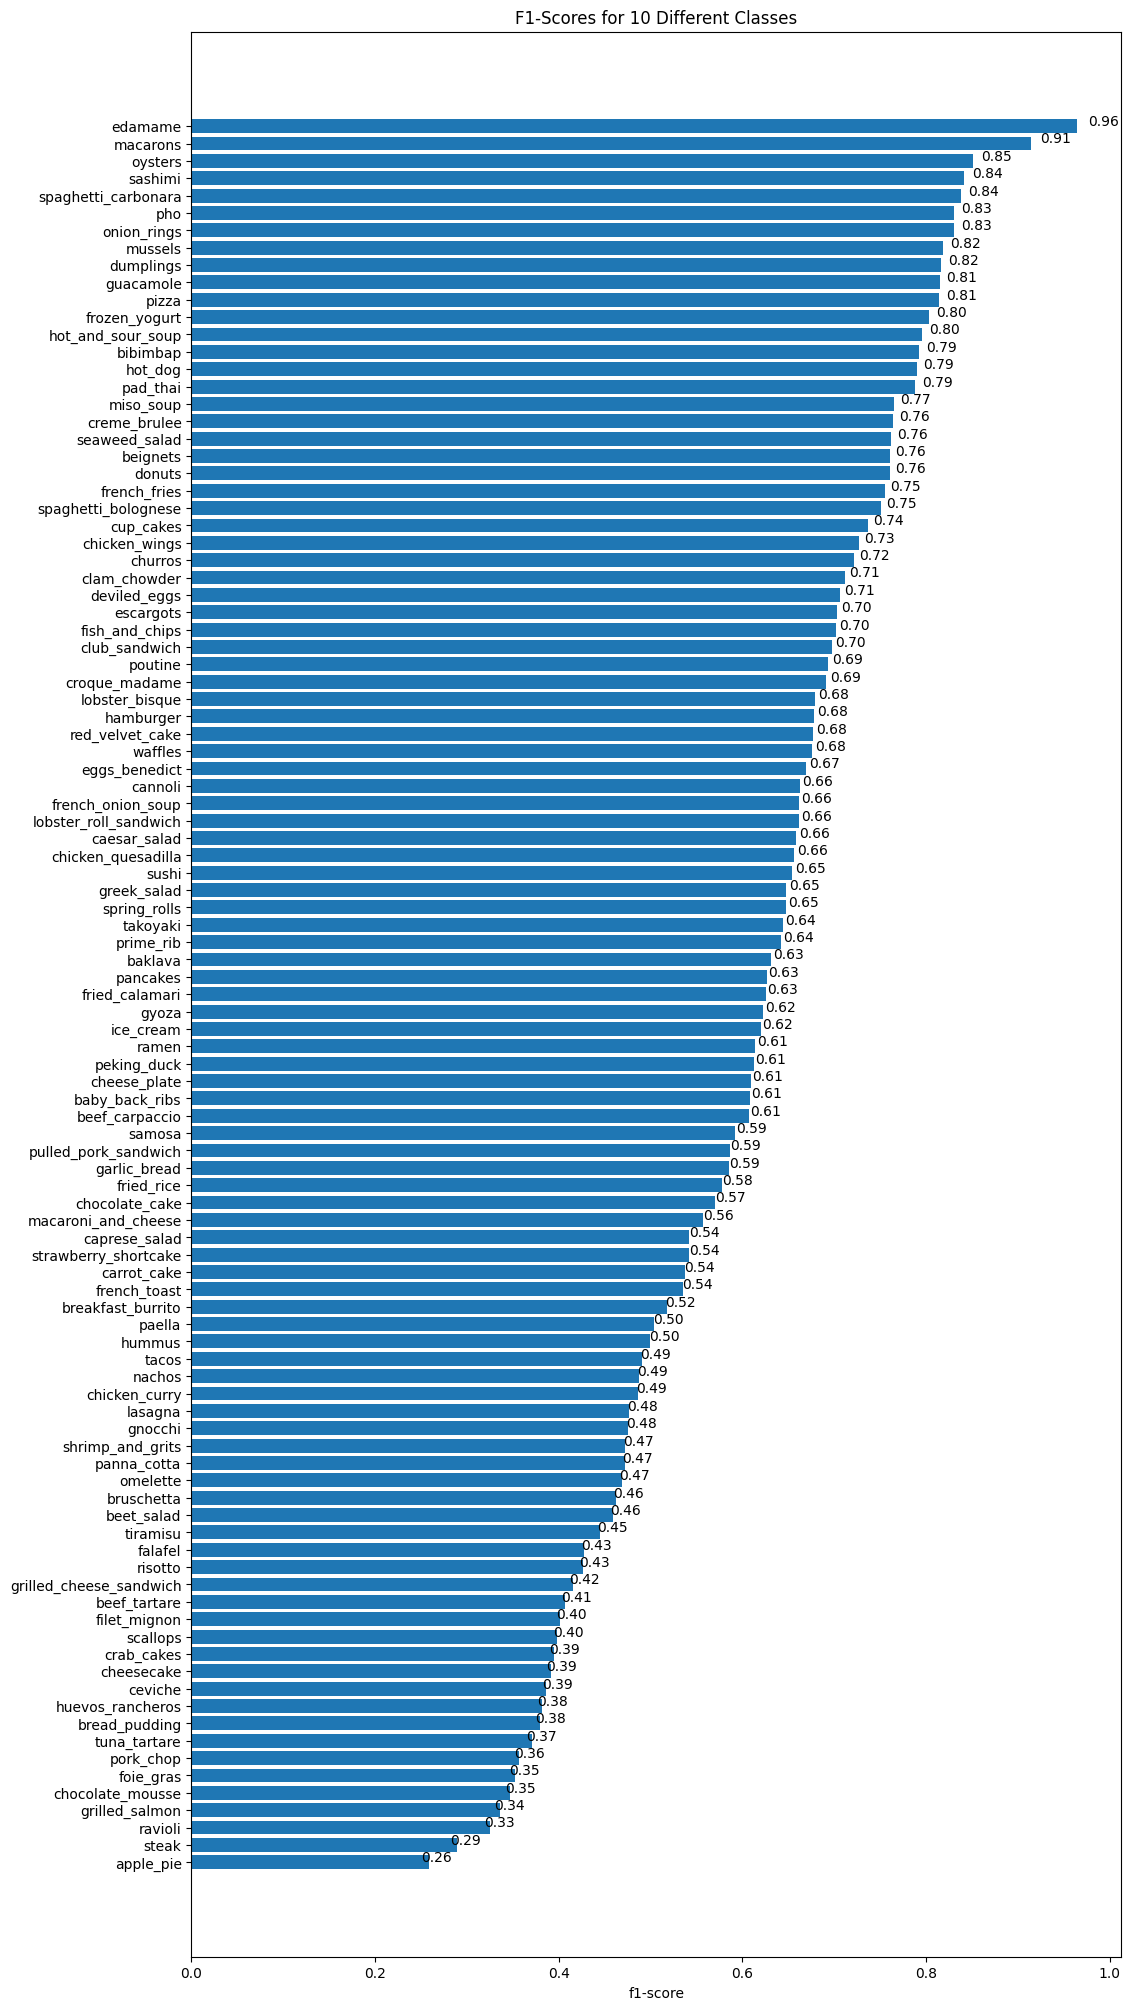

In [46]:
# Creating a horizontal bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing Predictions on a test images
So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

Read in a target image filepath using tf.io.read_file().
Turn the image into a Tensor using tf.io.decode_image().
Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
Scale the image to get all the pixel values between 0 & 1 if necessary.

In [47]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 41ms/step


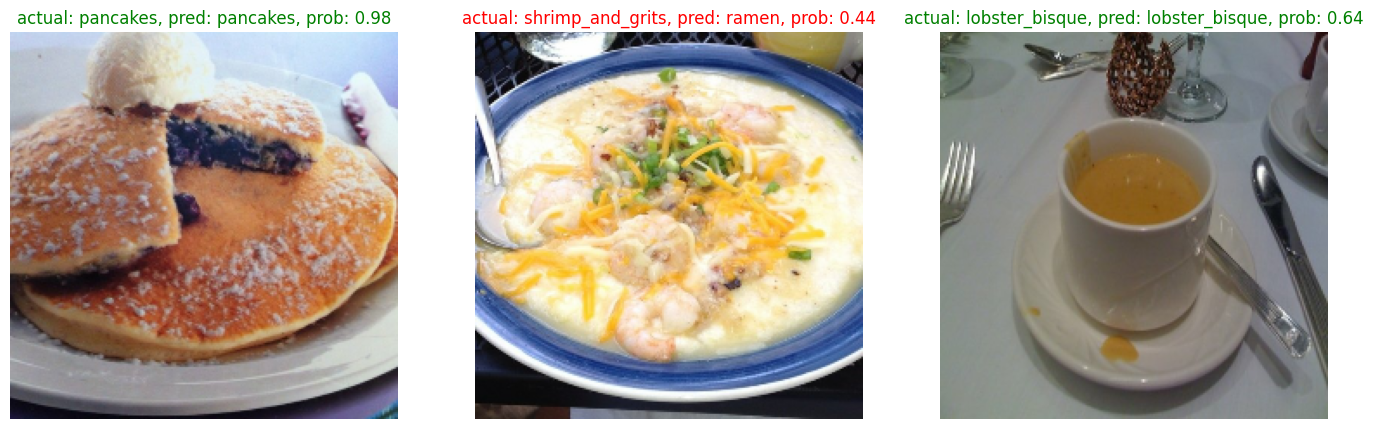

In [48]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as baby_back_ribs getting mistaken as steak and vice versa.

## Finding the most wrong predictions
These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.

**Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [49]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

Their ground truth labels (y_labels).
The class the model predicted (pred_classes).
The maximum prediction probabilitity value (pred_probs.max(axis=1)).
The ground truth class names.
The predicted class names.

In [50]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.300947        apple_pie        apple_pie  
1   0.958485        apple_pie        apple_pie  
2   0.594483        apple_pie        apple_pie  
3   0.193817        apple_pie    bread_pudding  
4   0.427810        apple_pie    bread_pudding

In [51]:

# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.300947        apple_pie        apple_pie          True  
1   0.958485        apple_pie        apple_pie          True  
2   0.594483        apple_pie        apple_pie          True  
3   0.193817        apple_pie    bread_pudding         False  
4   0.427810        apple_pie    bread_pudding         False

In [52]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
14630  b'101_food_classes_10_percent/test/ice_cream/3...      58      78   
11146  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
12487  b'101_food_classes_10_percent/test/grilled_che...      49      25   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   

       pred_conf         y_true_classname     y_pred_classname  pred_correct  
17855   0.998819                   paella              mussels         False  
18001   0.998748                 pancakes             omelette         False  
191     0.997553                apple_pie               donuts         False  
23631   0.997300     strawberry_shortcake      red_velvet_cake         False  
15142   0.997252           lobster_bisque            miso_soup         False  
23797   0.996540                    sushi              sashimi         False  
8794    0.995469                escargots    french_onion_soup         False  
11642   0.994788             garlic_bread           bruschetta         False  
10847   0.993369           fried_calamari          onion_rings         False  
23300   0.992714                    steak       baby_back_ribs         False  
16271   0.992708                  mussels              oysters         False  
21810   0.992014                 scallops            cup_cakes         False  
19430   0.991977                pork_chop       baby_back_ribs         False  
722     0.991799                  baklava               samosa         False  
14691   0.991367                ice_cream            prime_rib         False  
9110    0.990623                  falafel               donuts         False  
14630   0.989663                ice_cream              poutine         False  
11146   0.989172               fried_rice  macaroni_and_cheese         False  
12487   0.989134  grilled_cheese_sandwich        club_sandwich         False  
13144   0.988982                    gyoza         spring_rolls         False

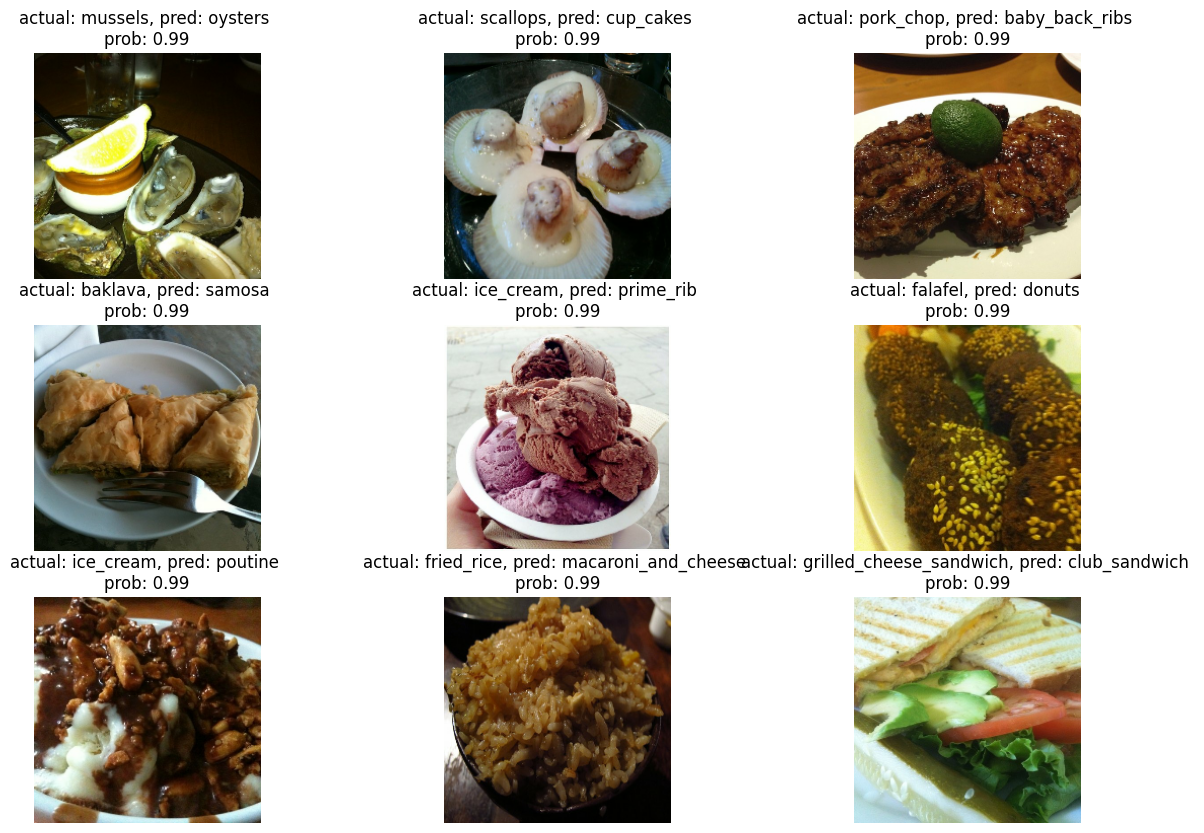

In [53]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [54]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-10-17 18:38:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 74.125.139.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  81.8MB/s    in 0.2s    

2023-10-17 18:38:02 (81.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [55]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images


['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 [==============================] - 0s 28ms/step


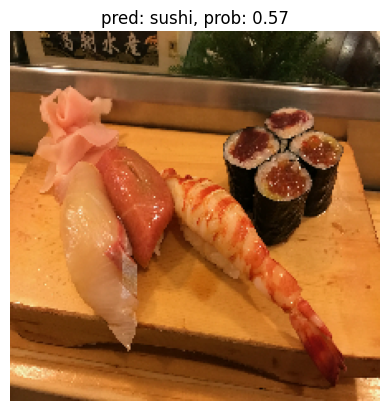

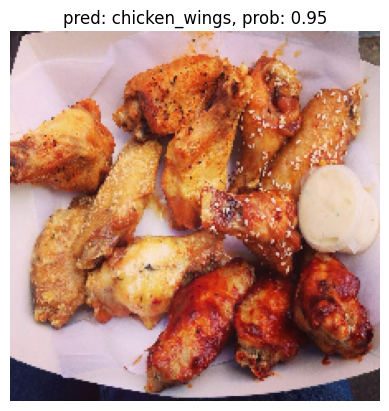

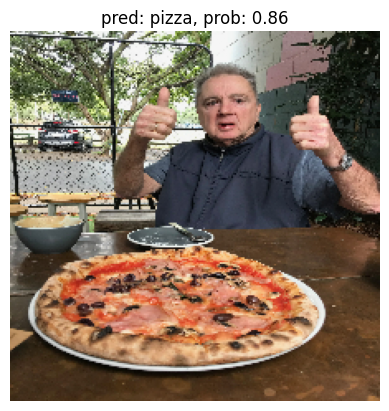

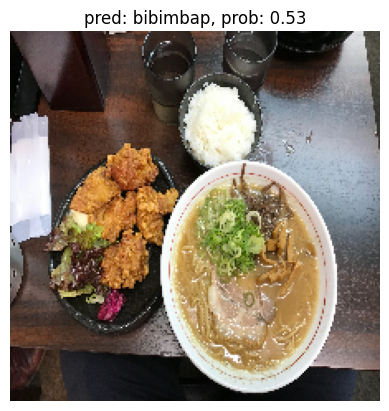

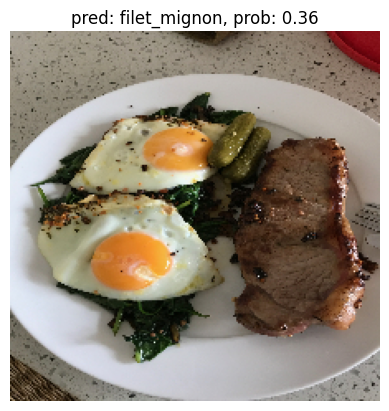

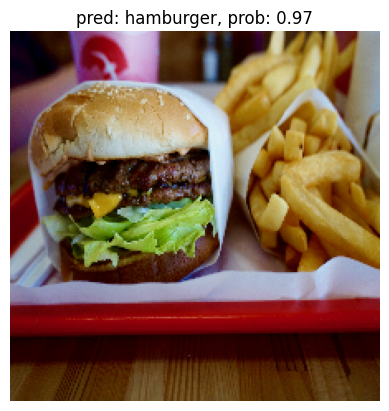

In [56]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)